In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving IMG0001.png to IMG0001.png
Saving IMG0002.png to IMG0002.png
Saving IMG0003.png to IMG0003.png
Saving IMG0004.png to IMG0004.png
Saving IMG0005.png to IMG0005.png
Saving IMG0006.png to IMG0006.png
Saving IMG0007.png to IMG0007.png
Saving IMG0008.png to IMG0008.png
Saving p12i1.png to p12i1.png
Saving p12i2.png to p12i2.png
Saving p12i3.png to p12i3.png
Saving p12i4.png to p12i4.png
Saving p12i5.png to p12i5.png
Saving p12i6.png to p12i6.png
Saving p12i7.png to p12i7.png
Saving p16i1.png to p16i1.png
Saving p16i2.png to p16i2.png
Saving p16i3.png to p16i3.png
Saving p16i4.png to p16i4.png
Saving p16i5.png to p16i5.png
Saving p16i6.png to p16i6.png
Saving p16i7.png to p16i7.png
Saving p16i8.png to p16i8.png
Saving p17i1.png to p17i1.png
Saving p17i2.png to p17i2.png
Saving p17i3.png to p17i3.png
Saving p17i4.png to p17i4.png
Saving p17i5.png to p17i5.png
Saving p17i6.png to p17i6.png
Saving p17i7.png to p17i7.png
Saving p17i8.png to p17i8.png
Saving p18i1.png to p18i1.png
Saving p

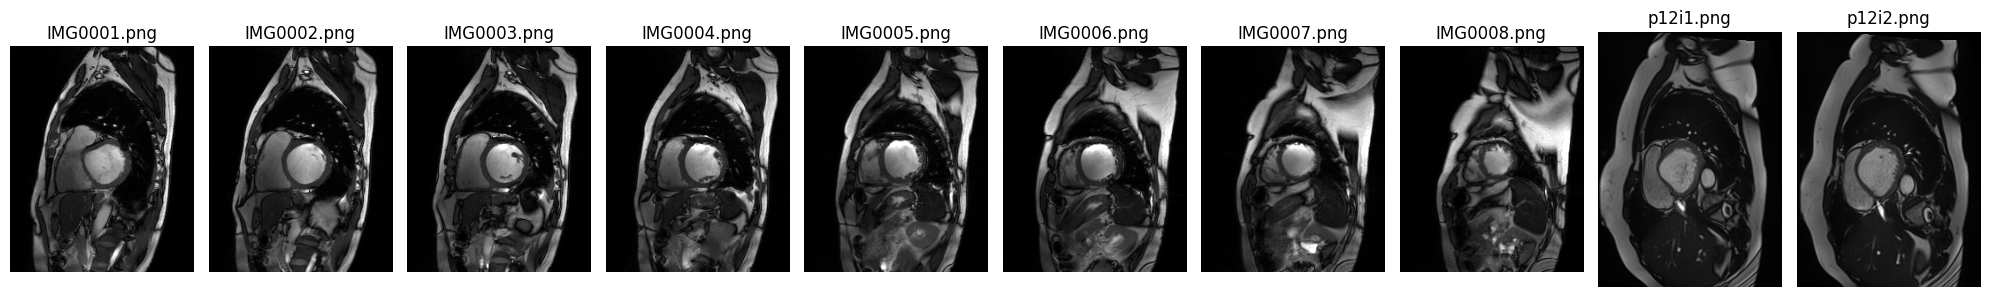

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import io

# List of the uploaded filenames
uploaded_files = list(uploaded.keys())

# First 10 images displayed
num_images_to_display = min(10, len(uploaded_files))

plt.figure(figsize=(20, 20))
for i, filename in enumerate(uploaded_files[:num_images_to_display]):
    img_data = uploaded[filename]
    img = Image.open(io.BytesIO(img_data)).convert('L')

    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=0.3
)


In [5]:
import os

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_dir = "./"
image_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]



In [7]:
print(len(image_files))


80


In [8]:
# Load and augment images
images = []
for img_file in image_files:
    img_path = os.path.join(img_dir, img_file)
    img = load_img(img_path, color_mode='grayscale', target_size=(56, 56))
    img_array = img_to_array(img)

    for _ in range(20):
        augmented_img = datagen.random_transform(img_array)
        images.append(augmented_img)

# Convert to numpy array and normalize
images = np.array(images) / 255.0


In [9]:


def plot_augmented_images(images, num_examples=10):

    plt.figure(figsize=(20, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(images[i].reshape(56, 56), cmap='gray')
        plt.axis('off')
    plt.show()


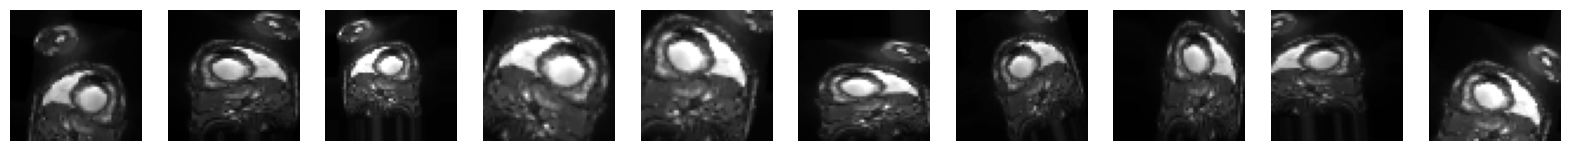

In [10]:
plot_augmented_images(images)


In [11]:

labels = np.zeros((len(images), 1))





In [12]:
print(len(images))
print(len(labels))


1600
1600


In [13]:
import tensorflow as tf

BUFFER_SIZE = len(images)
BATCH_SIZE = 20

# Convert to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, UpSampling2D, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [15]:
noise_dim = 100

def build_generator(noise_dim):
    model = Sequential()

    model.add(Dense(128 * 14 * 14, input_dim=noise_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((14, 14, 128)))
    model.add(Dropout(0.4))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))  # Producing [-1, 1] due to tanh

    noise = Input(shape=(noise_dim,))
    img = model(noise)

    return Model(noise, img)

In [16]:
def build_discriminator(img_shape):

    init = RandomNormal(stddev=0.02)
    model = Sequential()


    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))

    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


In [17]:
from keras.initializers import RandomNormal




def build_combined():
    # Build and compile the discriminator
    discriminator = build_discriminator((56, 56, 1))
    discriminator.compile(loss=['binary_crossentropy'],
                          optimizer=Adam(0.0001, 0.5),
                          metrics=['accuracy'])

    # Ensure the discriminator doesn't get updated during the combined model training
    discriminator.trainable = False

    # Build the generator
    generator = build_generator(noise_dim)

    # The generator takes noise as input and generates imgs
    z = Input(shape=(noise_dim,))
    img = generator(z)

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # Combined model
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate=0.0004, beta_1=0.5))

    return generator, discriminator, combined

generator, discriminator, combined = build_combined()


1/1 [==============================] - 0s 24ms/step
0/400 [D avg loss: 1.3683021913690752e-05 | D accuracy: 50.0] [G avg loss: 1.1571782513088034e-09]
1/1 [==============================] - 0s 230ms/step


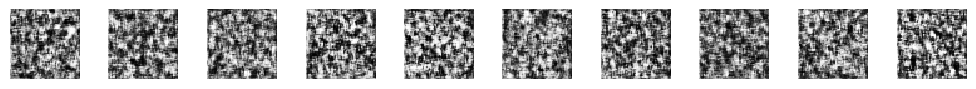

1/1 [==============================] - 0s 19ms/step
1/400 [D avg loss: 1.0507560168848684e-05 | D accuracy: 50.0] [G avg loss: 1.0025751895348378e-09]
1/1 [==============================] - 0s 28ms/step
2/400 [D avg loss: 8.990903815475626e-06 | D accuracy: 50.0] [G avg loss: 5.322617241051985e-10]
1/1 [==============================] - 0s 22ms/step
3/400 [D avg loss: 8.058003491040466e-06 | D accuracy: 50.0] [G avg loss: 3.631910827639473e-10]
1/1 [==============================] - 0s 17ms/step
4/400 [D avg loss: 6.971305934494465e-06 | D accuracy: 50.0] [G avg loss: 2.2320780128717854e-10]
1/1 [==============================] - 0s 21ms/step
5/400 [D avg loss: 6.371646935499076e-06 | D accuracy: 100.0] [G avg loss: 1.8117621005883654e-10]
1/1 [==============================] - 0s 18ms/step
6/400 [D avg loss: 5.664639326768972e-06 | D accuracy: 100.0] [G avg loss: 1.3989325422895938e-10]
1/1 [==============================] - 0s 22ms/step
7/400 [D avg loss: 5.002511779178542e-06 | D ac

KeyboardInterrupt: ignored

In [18]:
import numpy as np
import matplotlib.pyplot as plt

epochs = 400
batch_size = 20

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
noise_dim = 100

# Function to display generated images
def plot_generated_images(epoch, generator, num_examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[num_examples, noise_dim])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(num_examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

def smooth_labels(y):
    # Randomly smooth labels
    factor = np.random.uniform(0.7, 1.2)
    y *= factor
    return y

# Pre-training the Discriminator
pre_train_epochs = 10
for epoch in range(pre_train_epochs):
    for batch_imgs in dataset:
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        valid_smooth = smooth_labels(valid)

        discriminator.train_on_batch(batch_imgs, valid_smooth)
        discriminator.train_on_batch(gen_imgs, fake)

d_loss_history = []
g_loss_history = []

for epoch in range(epochs):
    d_losses = []
    g_losses = []

    for batch_imgs in dataset:
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        valid_smooth = smooth_labels(valid)

        d_loss_real = discriminator.train_on_batch(batch_imgs, valid_smooth)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = combined.train_on_batch(noise, valid)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)
    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)

    d_loss_history.append(avg_d_loss)
    g_loss_history.append(avg_g_loss)

    print(f"{epoch}/{epochs} [D avg loss: {avg_d_loss} | D accuracy: {100*d_loss[1]}] [G avg loss: {avg_g_loss}]")

    if epoch % 10 == 0:
        plot_generated_images(epoch, generator)




In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(generated_imgs, sampled_labels, num_examples=10):
    plt.figure(figsize=(10, num_examples//2))

    for i in range(num_examples):
        plt.subplot(num_examples//10, 10, i+1)
        plt.imshow(gen_imgs[i, :, :, 0], interpolation='nearest', cmap='gray_r')
        plt.title(f"Label: {sampled_labels[i][0]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:

num_examples = 10

# Random noise as input for the generator
noise = np.random.normal(0, 1, size=[num_examples, noise_dim])

# to generate images
generated_images = generator.predict(noise)

# Visualization function
def visualize_generated_images(generated_imgs, num_examples=10):
    plt.figure(figsize=(15, num_examples // 2))

    for i in range(num_examples):
        plt.subplot(num_examples // 5, 5, i + 1)
        plt.imshow(generated_imgs[i, :, :, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call function to visualize the images
visualize_generated_images(generated_images)



In [ ]:
# Plot Discriminator and Generator loss
plt.figure(figsize=(15, 5))

plt.plot(d_loss_history, label="Discriminator Loss")
plt.plot(g_loss_history, label="Generator Loss")

plt.title("GAN Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
